In [1]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import util
pd.options.mode.chained_assignment = None  # default='warn'
%matplotlib inline

In [2]:
artist_df = pd.read_pickle('data/artist_04092018.pkl')
exhibition_df = pd.read_pickle('data/exhibition_04092018.pkl')

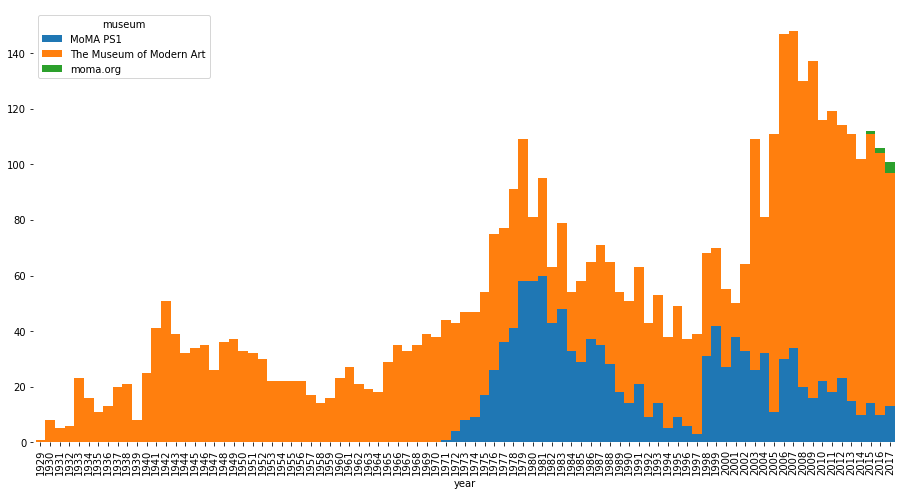

In [73]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
plt.subplots_adjust(left=-0.5, bottom=-0.5, right=0.5, top=0.5, wspace=0.2, hspace=0.3)

fil = (exhibition_df['year']!=-1) & \
      (exhibition_df['year'] < 2018) & \
      ((exhibition_df['museum'] == "The Museum of Modern\xa0Art") | \
       (exhibition_df['museum'] == "MoMA\xa0PS1") | \
       (exhibition_df['museum'] == "moma.org"))
    
exhibition_df[fil].groupby(['year', 'museum'])['year', 'museum'] \
    .size() \
    .reset_index(name='counts') \
    .sort_values(by='year') \
    .pivot(index='year', columns='museum', values='counts') \
    .fillna(0) \
    .reset_index() \
    .plot.bar(x='year', stacked=True, ax=ax1, width=1, linewidth=0)

In [3]:
def artist_by_exhibit_year(year, museum='moma'):
    """
    Gets artists by year of exhibition.
    """
    if museum == 'moma':
        museum = "The Museum of Modern\xa0Art"
    if museum == 'ps1': 
        museum = "MoMA\xa0PS1"
    if museum == 'moma.org':
        museum = "moma.org"
    
    # get artists from a specific year of exhibitions
    fil = (exhibition_df['artists'] != '') & (exhibition_df['year'] == year) & (exhibition_df['museum'] == museum)
    artist_filter = ', '.join(list(exhibition_df[fil]["artists"])).split(', ')
    artist_filter_df = pd.DataFrame(artist_filter, columns=["artist_name"])
    
    # join the list of artists with artists_df to get race/gender/nationality data
    artist_filter_merged_df = artist_filter_df.merge(artist_df[["artist_name", "race", "gender", "nationality"]], on=["artist_name"])

    return artist_filter_merged_df

In [4]:
def plot_time_series(fil, start, end, title, museum='moma', style="--", omit=[], top=10):
    """
    Plots time series of data by a specified 'filter'
    fil = "race", "gender", or "nationality"
    start/end = start or end year
    title = title of chart
    style = "--" line graph, "=" stacked bar graph
    omit = values to omit (such as "white")
    """
    title = title + " between %i and %i"%(start, end)
    
    # plot settings
    fig = plt.figure(figsize=(12, 12))
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)

    plt.subplots_adjust(left=-0.5, bottom=-0.5, right=0.5, top=0.5, wspace=0.2, hspace=0.3)
    
    time_series = pd.DataFrame([], columns=["year"])
    
    # collect artist through each year (end - start)
    for i in range(start, end):
        t = artist_by_exhibit_year(i, museum) #.to_dict()
        t = t[(t['race'] != '') & (t['gender'] != '')][fil].value_counts(dropna=True).to_dict()
        t['year'] = str(i)
        time_series = time_series.append(t, ignore_index=True)

    time_series = time_series.set_index("year")
    time_series = time_series.fillna(value=0)
    
    # omit columns
    if len(omit) > 0:
        time_series = time_series.drop(omit, axis=1)
        
    # get top 10 at max
    column_filter = time_series.sum().sort_values(ascending=False).index[:top]
    time_series = time_series[column_filter]

    # plot quantity
    if style == "--":
        time_series.plot(ax=ax1, title=title, linewidth=0)
    if style == "=":
        time_series.plot.bar(ax=ax1, title=title, stacked=True, width=1, linewidth=0)
    ax1.set_ylim(bottom=0)
    ax1.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax1.set_xlabel('')
    ax1.set_ylabel('# of artists who exhibited')

    # plot pct
    feature_pct_df = time_series.divide(time_series.sum(axis=1) +.000000001, axis=0)
    if style == "--":
        feature_pct_df.plot(ax=ax2, title=title + " [PCT]", edgecolor = "none")
    if style == "=":
        feature_pct_df.plot.bar(ax=ax2, title=title + " [PCT]", stacked=True, width=1, edgecolor = "none")
    ax2.set_ylim(top=1, bottom=0)    
    ax2.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
    ax2.set_xlabel('')
    ax2.set_ylabel('% of artists who exhibited')

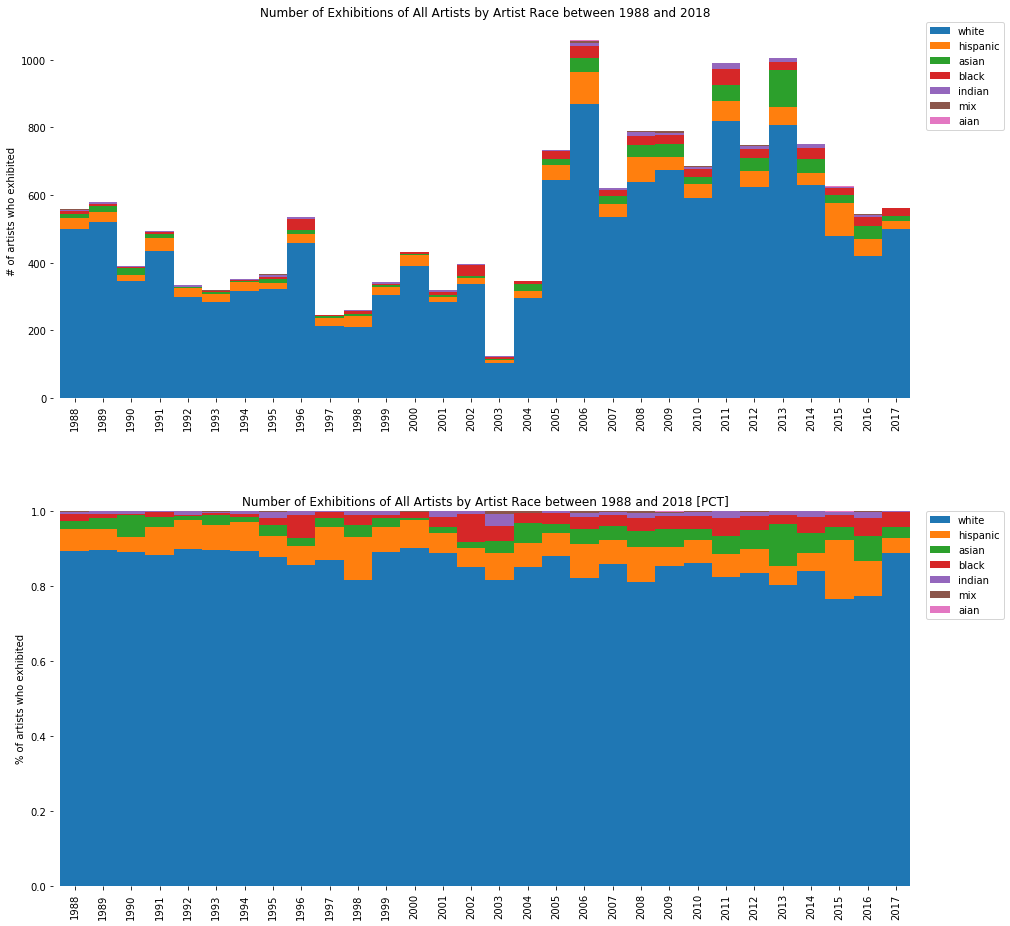

In [77]:
plot_time_series(fil="race", \
                 start=1988, \
                 end=2018, \
                 museum='moma', \
                 style="=", \
                 title="Number of Exhibitions of All Artists by Artist Race", \
                 omit=[])

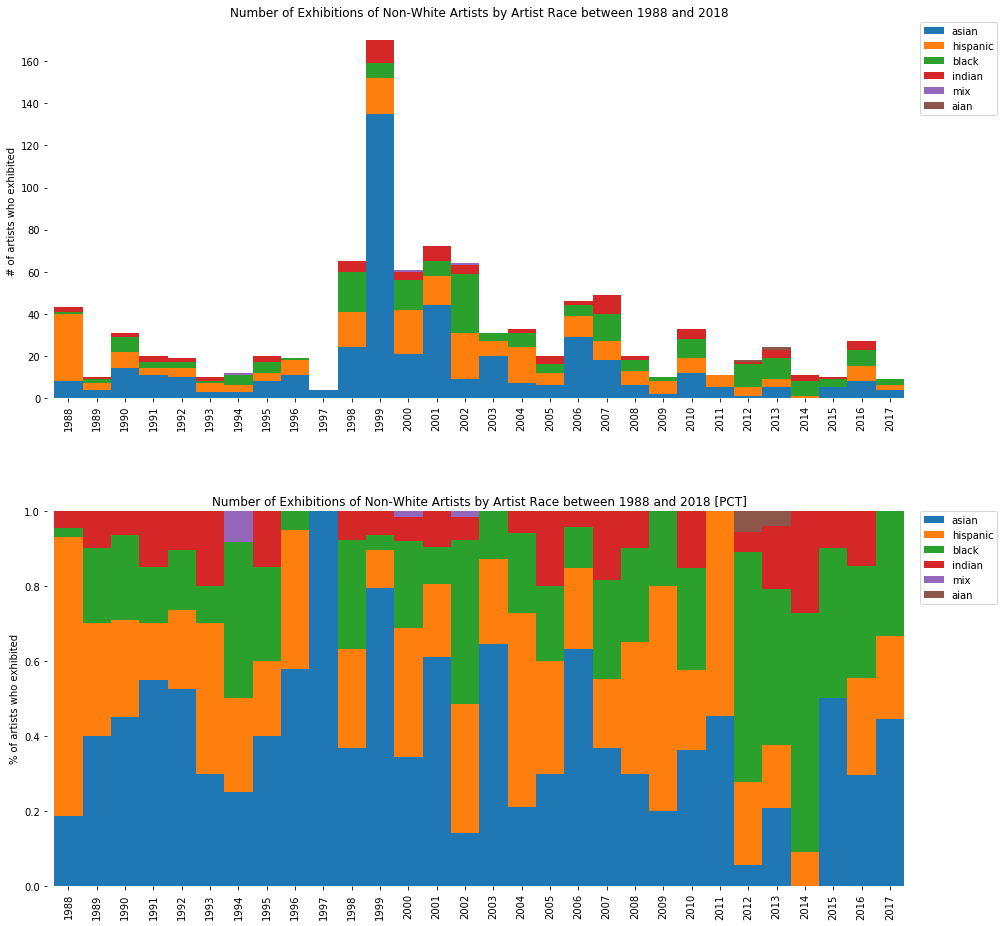

In [6]:
plot_time_series(fil="race", \
                 start=1988, \
                 end=2018, \
                 style="=", \
                 museum='ps1', \
                 title="Number of Exhibitions of Non-White Artists by Artist Race", \
                 omit=["white"])

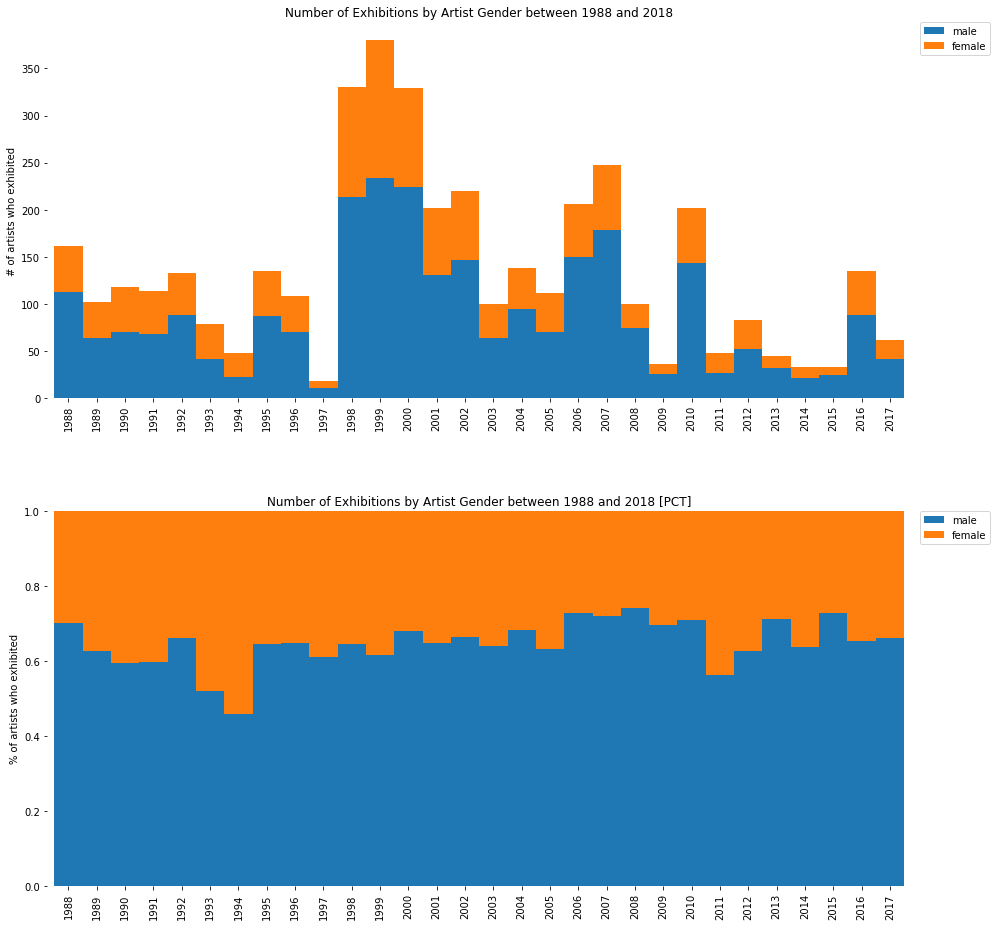

In [7]:
plot_time_series(fil="gender", \
                 start=1988, \
                 end=2018, \
                 style="=", \
                 museum='ps1', \
                 title="Number of Exhibitions by Artist Gender", \
                 omit=["None"])

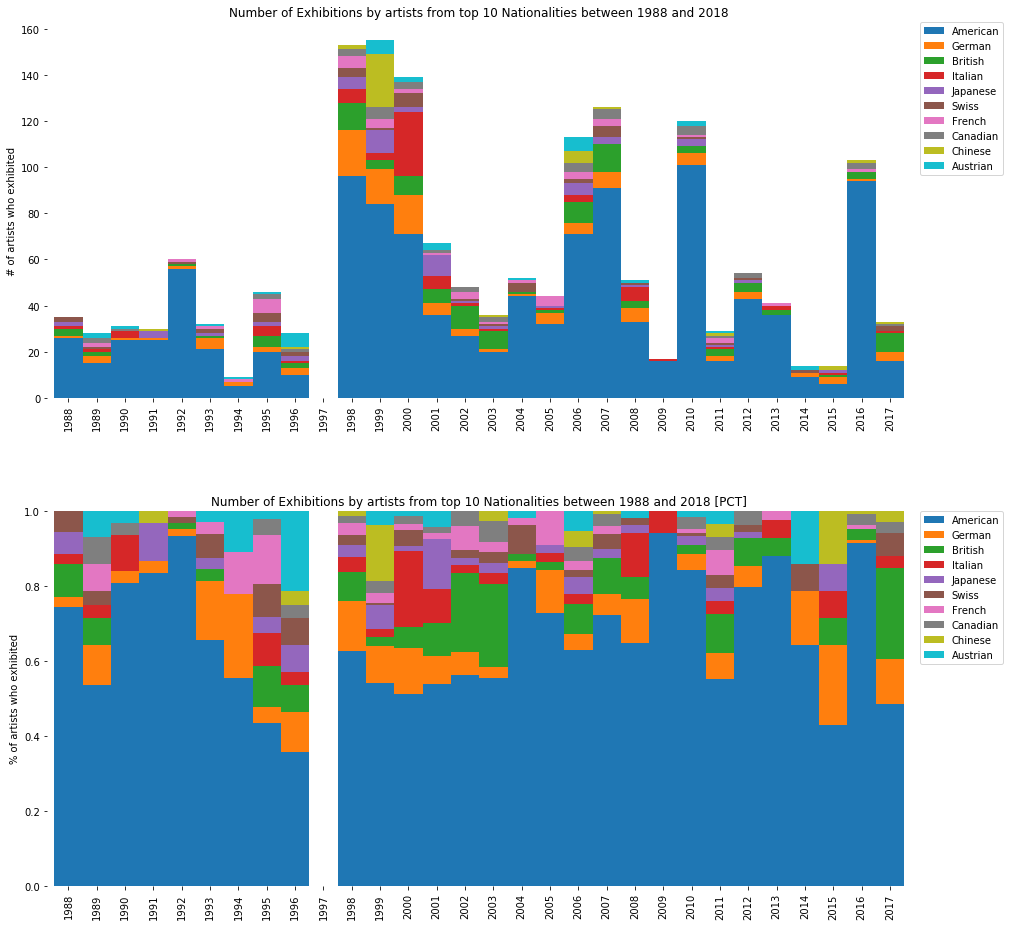

In [8]:
plot_time_series(fil="nationality", \
                 start=1988, \
                 end=2018, \
                 style="=", \
                 museum='ps1', \
                 title="Number of Exhibitions by artists from top 10 Nationalities", \
                 omit=[""])

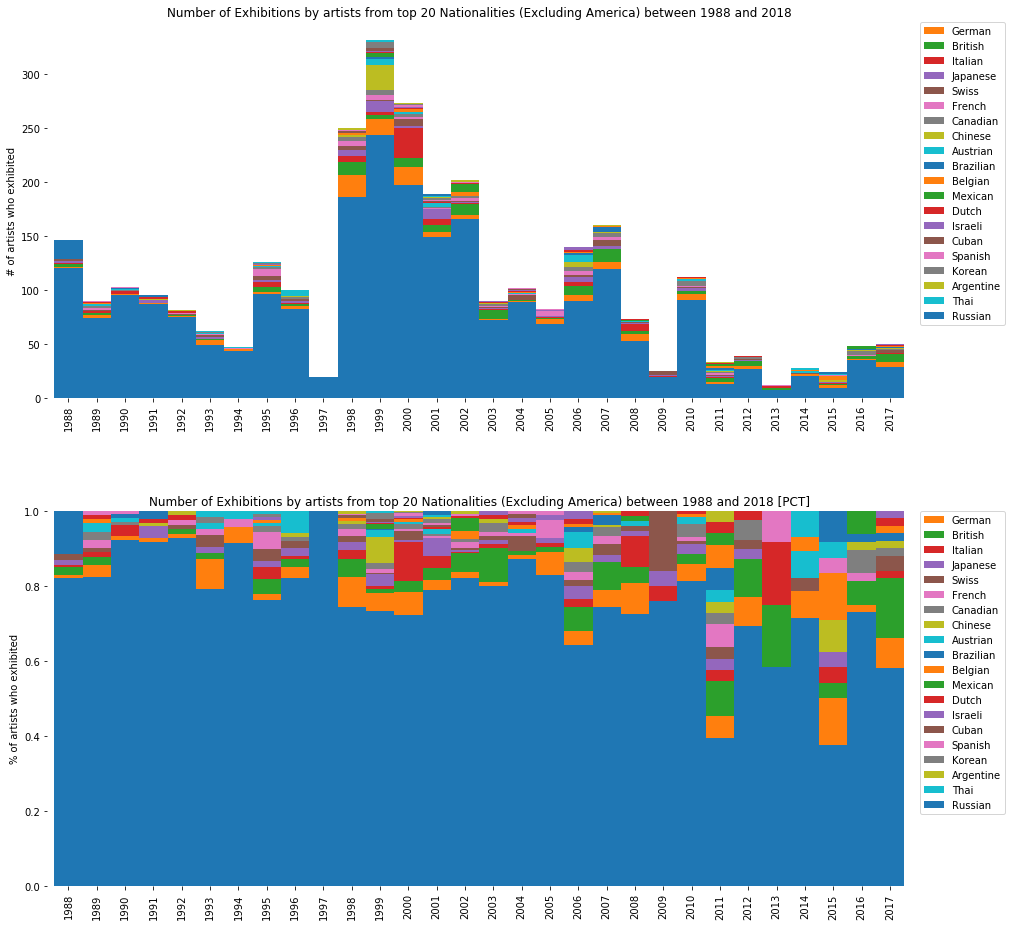

In [9]:
plot_time_series(fil="nationality", \
                 start=1988, \
                 end=2018, \
                 style="=", \
                 museum='ps1', \
                 title="Number of Exhibitions by artists from top 20 Nationalities (Excluding America)", \
                 omit=["American"], \
                 top=21)

In [75]:
def plot_race_gender_across_years(years=[1957, 1977, 1997, 2017]):
    """
    This function will print out 2 graphs to show the race and gender distribution of artists who have
    exhibited at the MoMA, across the 4 years that
    """
    df_array = []
    for year in years:
        df_array.append(artist_by_exhibit_year(year))

    fig = plt.figure(figsize=(12, 15))
    plt.subplots_adjust(left=-0.5, bottom=-0.5, right=0.5, top=0.5, wspace=0.2, hspace=0.5)
    
    axes = []
    for i in range(1, 2 * len(years) + 1):
        a = fig.add_subplot(4, 2, i)
        axes.append(a)
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        a.spines['left'].set_visible(False)

    for i, year in enumerate(years):
        util.plot_distribution(dist_df=df_array[i][df_array[i]['race']!='']['race'].value_counts(dropna=True),
            title="Race Distribution of \n Artists Who Have Exhibited During %s"%str(year),
            ax=axes[2*i])

        util.plot_distribution(dist_df=df_array[i][df_array[i]['gender']!='None']['gender'].value_counts(dropna=True),
            title="Gender Distribution of \n Artists Who Have Exhibited During %s"%str(year),
            ax=axes[(2*i)+1])
        

def plot_nationality_across_years(years=[1957, 1977, 1997, 2017]):
    """
    This function will print out 2 graphs to show the race and gender distribution of artists who have
    exhibited at the MoMA, across the 4 years that
    """
    df_array = []
    for year in years:
        df_array.append(artist_by_exhibit_year(year))

    fig = plt.figure(figsize=(12, 15))
    plt.subplots_adjust(left=-0.5, bottom=-0.5, right=0.5, top=0.5, wspace=0.2, hspace=0.5)
    
    axes = []
    for i in range(1, len(years) + 1):
        a = fig.add_subplot(4, 1, i)
        axes.append(a)
        a.spines['top'].set_visible(False)
        a.spines['right'].set_visible(False)
        a.spines['left'].set_visible(False)

    for i, year in enumerate(years):
        util.plot_distribution(dist_df=df_array[i][df_array[i]['nationality']!='']['nationality'].value_counts(dropna=True)[:10],
            title="Nationality Distribution of \n Artists Who Have Exhibited During %s"%str(year),
            ax=axes[i], show_pct=False)

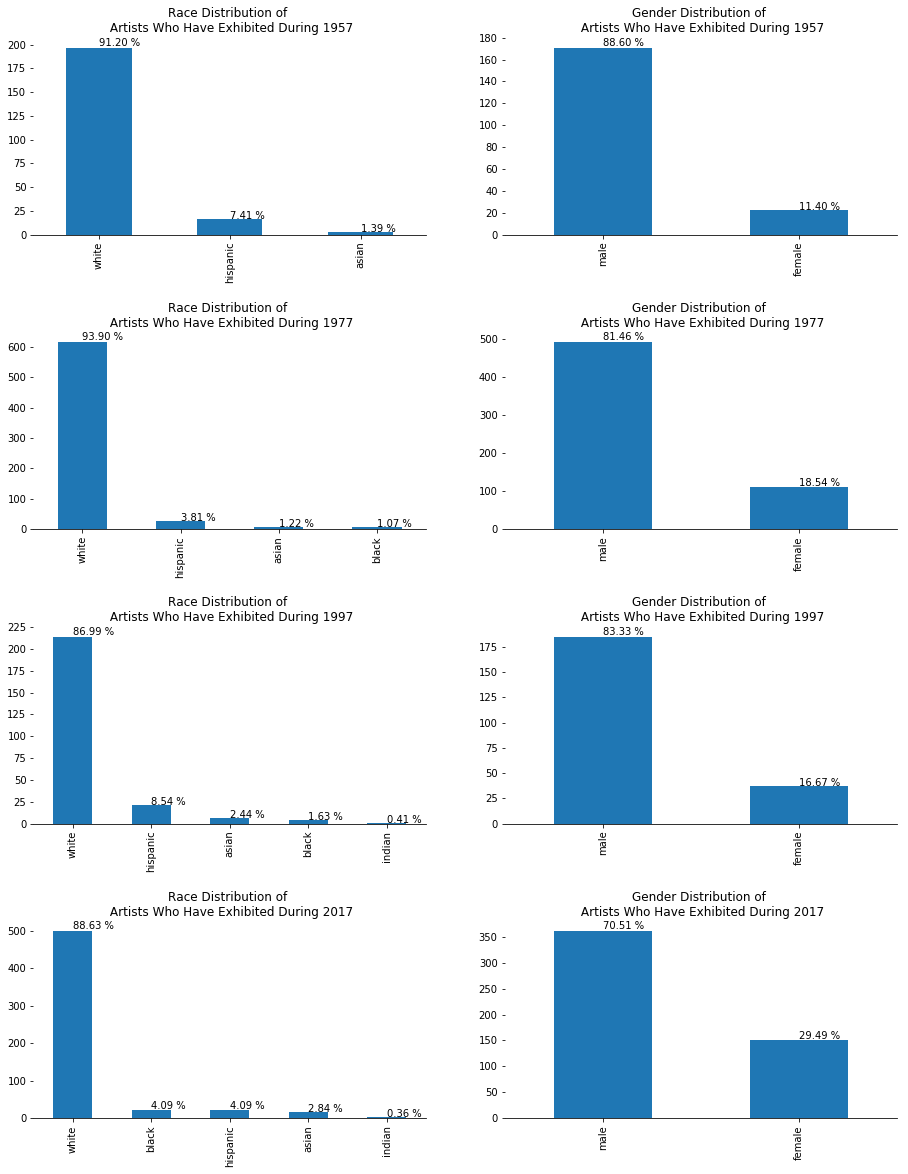

In [11]:
plot_race_gender_across_years(years=[1957, 1977, 1997, 2017])

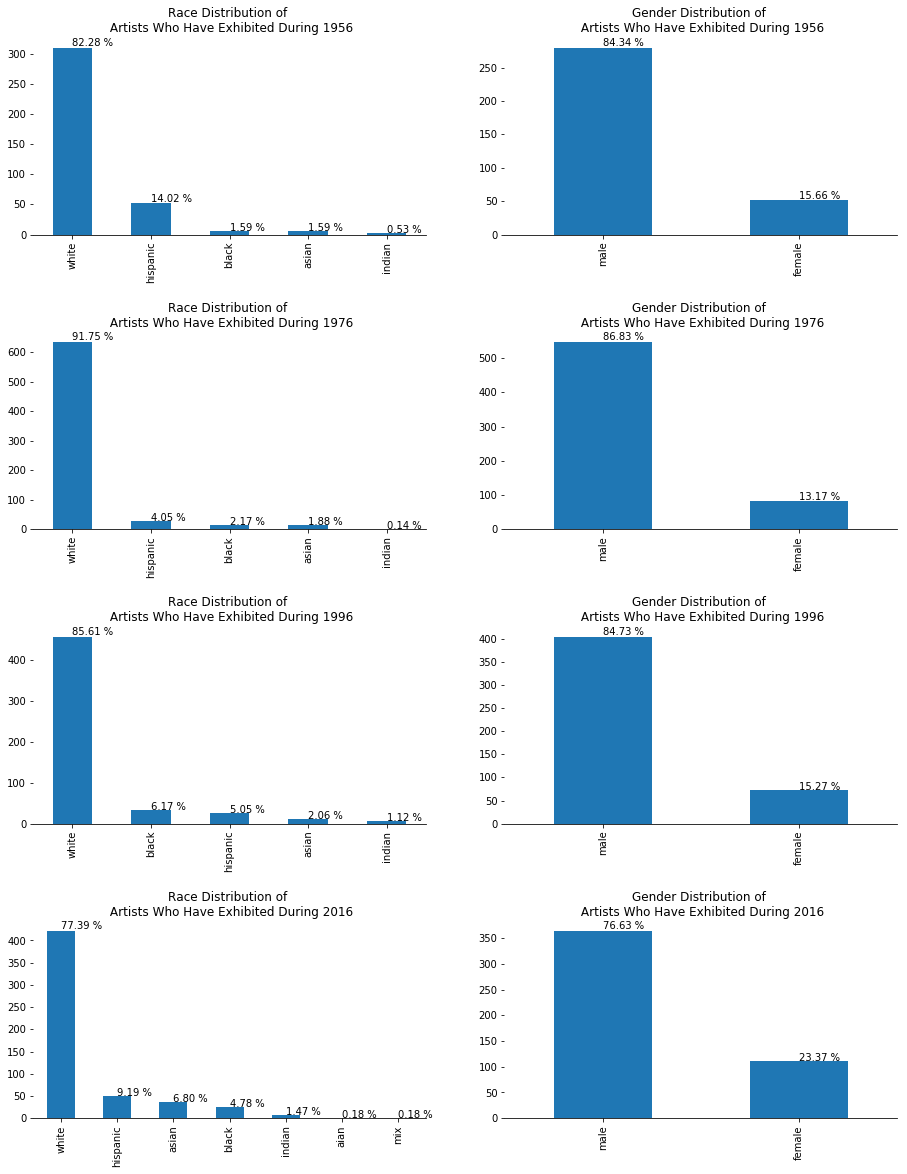

In [12]:
plot_race_gender_across_years(years=[1956, 1976, 1996, 2016])

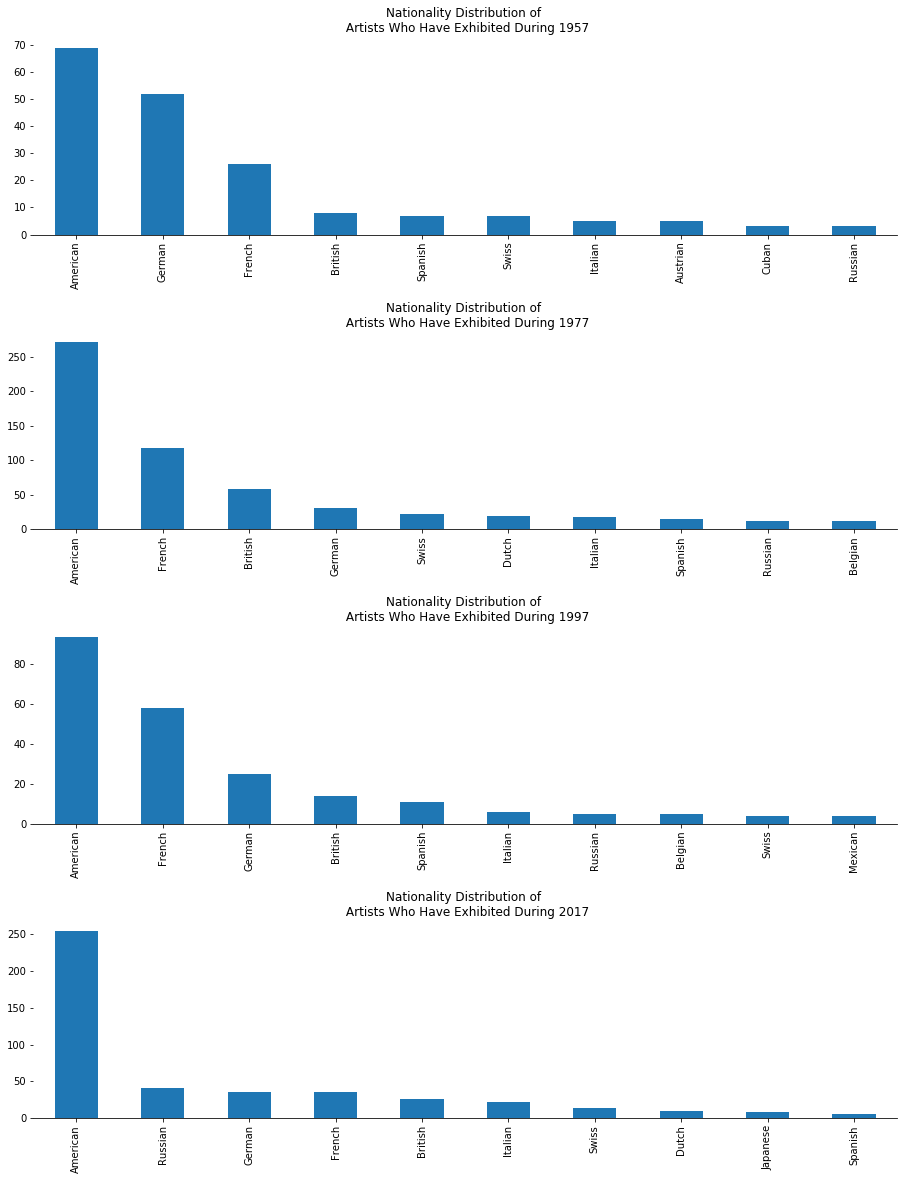

In [76]:
plot_nationality_across_years()

In [14]:
def get_top_exhibited_artists(start, end, top=50):
    time_series = pd.DataFrame([])

    for i in range(start, end):
        t = artist_by_exhibit_year(i)
        time_series = time_series.append(t, ignore_index=True)

    ret = time_series.groupby(time_series.columns.tolist(), as_index=False)\
        .size().reset_index().rename(columns={0: 'count'})\
        .sort_values(by='count', ascending=False)\
        .reset_index().drop("index", axis=1).iloc[0:top]
    
    return ret

In [15]:
get_top_exhibited_artists(2007, 2017, top=45).head() # ['race'].value_counts()

# in the past 10 years, there have been 181 artists whose work has been exhibited more than 5 times
# of those 181, only 15 (8%) are PoC (9 hispanics, 2 blacks, and 4 asians)

# in the past 10 years, there have been 45 artists whose work has been exhibited more than 10 times
# of those 45, only 5 (11%) are PoC (2 hispanics, 1 blacks, and 2 asians)

,artist_name,race,gender,nationality,count
0,Pablo Picasso,hispanic,male,Spanish,19
1,Bruce Nauman,white,male,American,19
2,Robert Rauschenberg,white,male,American,19
3,Man Ray (Emmanuel Radnitzky),white,male,American,18
4,John Baldessari,white,male,American,16


relevant links:
- https://news.artnet.com/exhibitions/bodys-isek-kingelez-moma-1104215